In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import warnings
import os
import pandas as pd
from tqdm import tqdm

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [54]:
# Initialize lists
images = []
labels = []
# Set the base directory
base_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

# Walk through the directory tree
for root, dirs, files in tqdm(os.walk(base_dir)):
    for file in files:
        # Construct the full image path
        image_path = os.path.join(root, file)
        # Extract the label from the parent folder name
        label = os.path.basename(os.path.dirname(image_path))
        # Append image path and label to respective lists
        images.append(image_path)
        labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'image': images, 'label': labels})

# Add space between capitalized words in the 'label' column
df['label'] = df['label'].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)

# Separate DataFrame into training and testing sets based on folder structure
df['set'] = df['image'].apply(lambda x: 'train' if 'train' in x else 'test')

# Split the DataFrame into training and testing DataFrames
df_train = df[df['set'] == 'train'].reset_index(drop=True)
df_test = df[df['set'] == 'test'].reset_index(drop=True)

# Display the training and testing DataFrames
df_train, df_test

11it [00:03,  2.96it/s]


(                                                  image              label  \
 0     /kaggle/input/alzheimers-dataset-4-class-of-im...  Moderate Demented   
 1     /kaggle/input/alzheimers-dataset-4-class-of-im...  Moderate Demented   
 2     /kaggle/input/alzheimers-dataset-4-class-of-im...  Moderate Demented   
 3     /kaggle/input/alzheimers-dataset-4-class-of-im...  Moderate Demented   
 4     /kaggle/input/alzheimers-dataset-4-class-of-im...  Moderate Demented   
 ...                                                 ...                ...   
 5116  /kaggle/input/alzheimers-dataset-4-class-of-im...      Mild Demented   
 5117  /kaggle/input/alzheimers-dataset-4-class-of-im...      Mild Demented   
 5118  /kaggle/input/alzheimers-dataset-4-class-of-im...      Mild Demented   
 5119  /kaggle/input/alzheimers-dataset-4-class-of-im...      Mild Demented   
 5120  /kaggle/input/alzheimers-dataset-4-class-of-im...      Mild Demented   
 
         set  
 0     train  
 1     train  
 2   

<Axes: ylabel='count'>

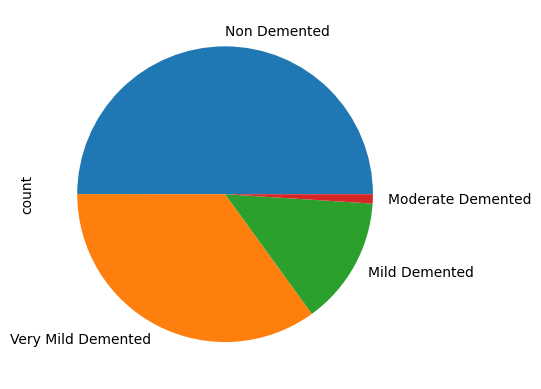

In [3]:
df_train.label.value_counts().plot(kind='pie')

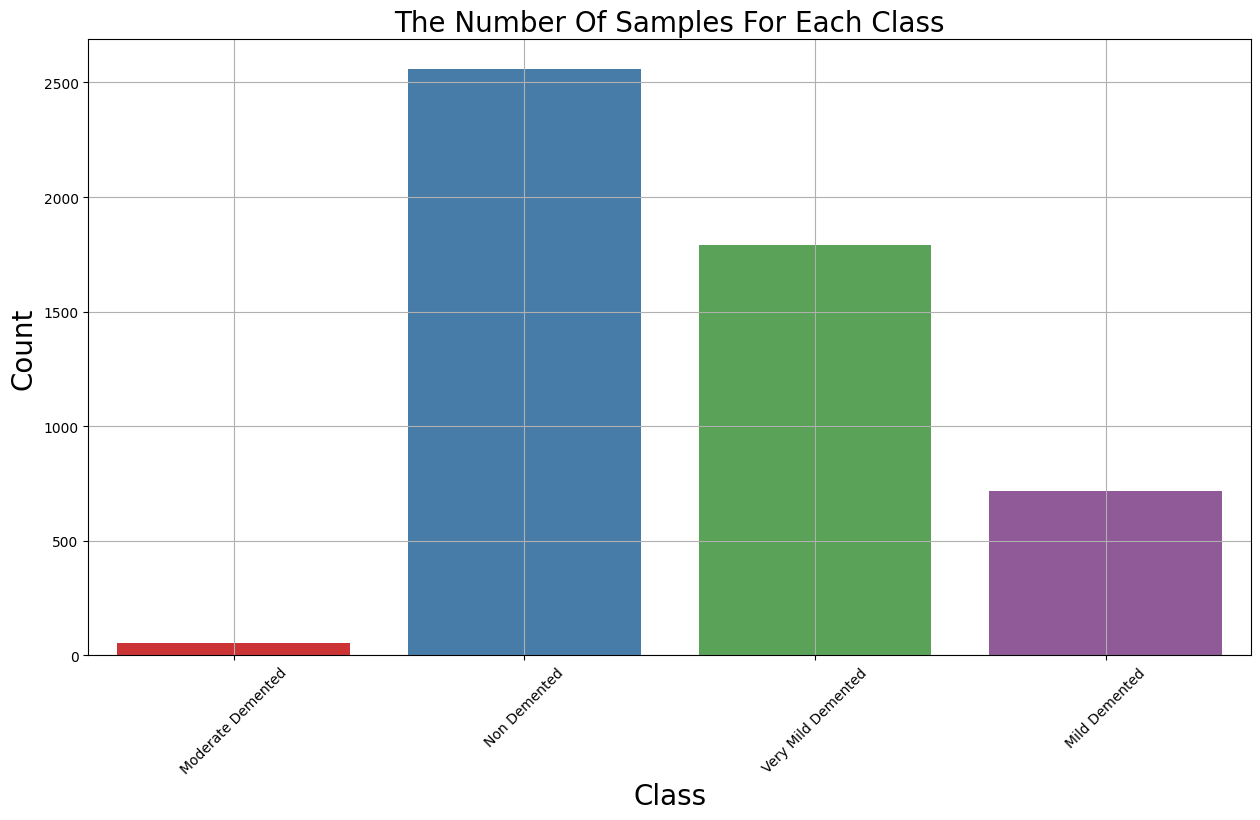

In [4]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df_train.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [56]:
# Take 10% of the training data for validation
train_df, validate_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])

# Reset the index for both DataFrames
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [57]:
train_df.shape

(4096, 3)

In [58]:
train_df.drop(columns='set',inplace=True)
validate_df.drop(columns='set',inplace=True)
df_test.drop(columns='set',inplace=True)

In [59]:
print(f"Shape of each one {train_df.shape} and {validate_df.shape}, and {df_test.shape}]")

Shape of each one (4096, 2) and (1025, 2), and (1279, 2)]


In [60]:
# Initialize the ImageDataGenerator with rescaling
gen = ImageDataGenerator(
    rescale=1./255
)

# Define the target image size
Size = (128, 128)

# Create the train generator
train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=Size,
    batch_size=4096,
    shuffle=True
)

# Create the validation generator
validate_gen = gen.flow_from_dataframe(
    validate_df,
    x_col='image',
    y_col='label',
    target_size=Size,
    batch_size=1025,
    shuffle=False
)

# Create the test generator
test_gen = gen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=Size,
    batch_size=1279,
    shuffle=False
)

Found 4096 validated image filenames belonging to 4 classes.
Found 1025 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


In [61]:
# Extract data and labels from train_gen
train_data, train_labels = next(train_gen)
print("Train Data:", train_data.shape, "Train Labels:", train_labels.shape)

# Extract data and labels from validate_gen
validate_data, validate_labels = next(validate_gen)
print("Validate Data:", validate_data.shape, "Validate Labels:", validate_labels.shape)

# Extract data and labels from test_gen
test_data, test_labels = next(test_gen)
print("Test Data:", test_data.shape, "Test Labels:", test_labels.shape)

Train Data: (4096, 128, 128, 3) Train Labels: (4096, 4)
Validate Data: (1025, 128, 128, 3) Validate Labels: (1025, 4)
Test Data: (1279, 128, 128, 3) Test Labels: (1279, 4)


In [11]:
class_num=np.sort(['Mild Demented','Moderate Demented','Non Demented','Very Mild Demented'])
class_num

array(['Mild Demented', 'Moderate Demented', 'Non Demented',
       'Very Mild Demented'], dtype='<U18')

## Generating Data

In [12]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 128 * 128 * 3), train_labels)
train_data = train_data.reshape(-1, 128,128, 3)
print(train_data.shape, train_labels.shape)

(8192, 128, 128, 3) (8192, 4)


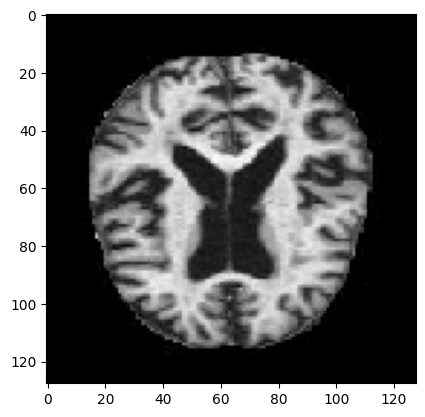

In [13]:
plt.imshow(train_data[851])

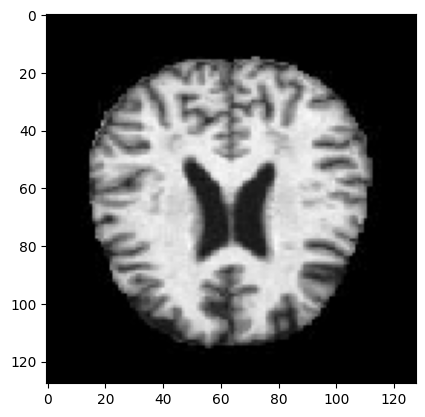

In [14]:
plt.imshow(test_data[851])

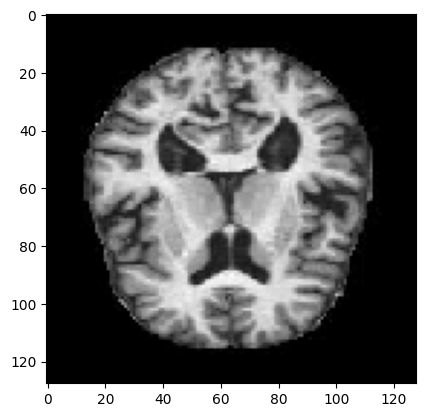

In [15]:
plt.imshow(validate_data[851])

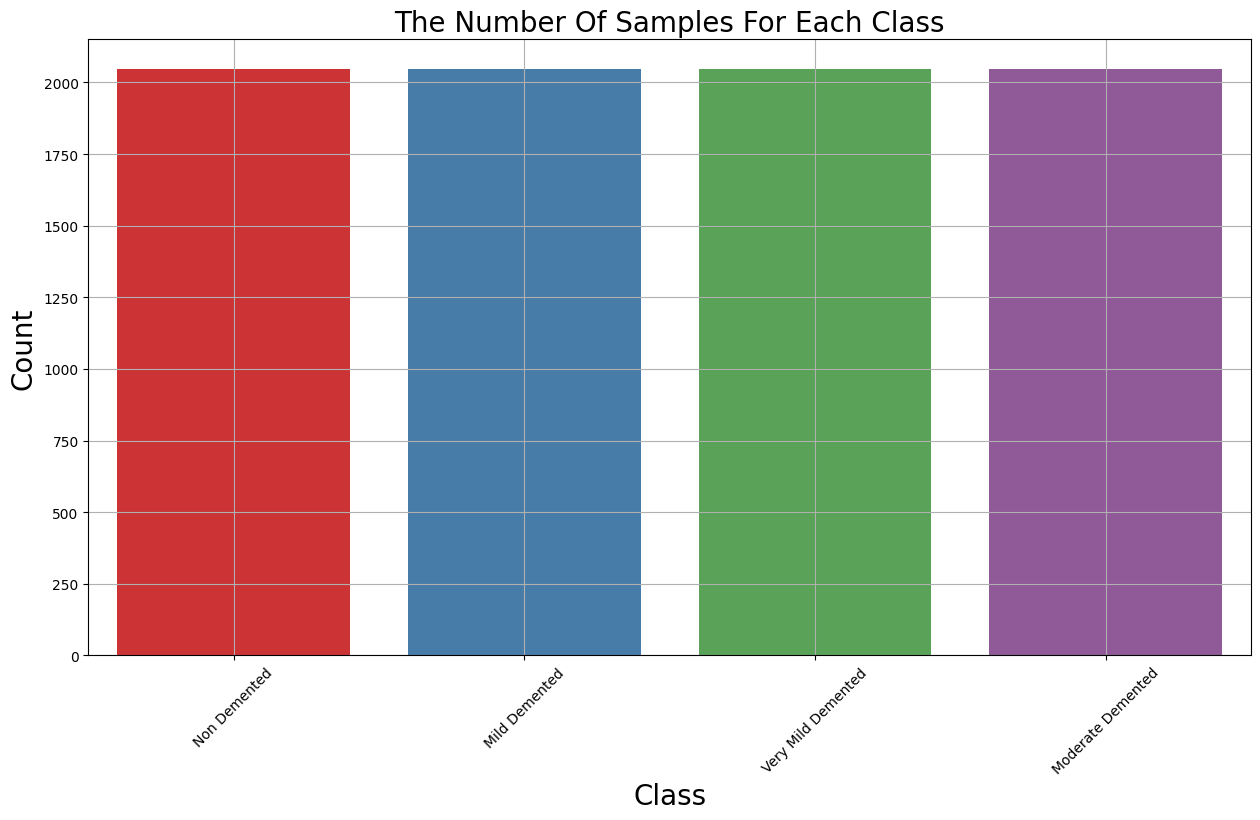

In [16]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## VGG16

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Load pre-trained VGG16 model + higher-level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the initial layers of VGG16
for layer in base_model.layers[:-4]:  # Unfreeze the last few layers if needed
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use Global Average Pooling instead of Flatten
x = BatchNormalization()(x)      # Add Batch Normalization
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Increase complexity and add L2 regularization
x = Dropout(0.5)(x)              # Add Dropout to prevent overfitting
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Additional Dense layer with L2 regularization
x = Dropout(0.5)(x)              # Add Dropout to the new Dense layer
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Another Dense layer with L2 regularization
x = Dropout(0.5)(x)              # Add Dropout to the new Dense layer
predictions = Dense(4, activation='softmax')(x)  # Adjust to the number of classes in your dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with an appropriate optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_data,train_labels, epochs=30, validation_data=(validate_data,validate_labels), callbacks=[model_checkpoint, early_stopping,reduce_lr])

Epoch 1/30


I0000 00:00:1726426443.281897     127 service.cc:145] XLA service 0x7df52c003d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726426443.281964     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726426443.281972     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/256 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.2188 - loss: 12.3086   

I0000 00:00:1726426456.088173     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


256/256 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.5085 - loss: 6.9385 - val_accuracy: 0.6312 - val_loss: 1.6650 - learning_rate: 0.0010
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7602 - loss: 1.1246 - val_accuracy: 0.2741 - val_loss: 2.8568 - learning_rate: 0.0010
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8492 - loss: 0.5580 - val_accuracy: 0.5298 - val_loss: 2.0694 - learning_rate: 0.0010
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9035 - loss: 0.3817 - val_accuracy: 0.5083 - val_loss: 3.5319 - learning_rate: 0.0010
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9256 - loss: 0.3449 - val_accuracy: 0.6624 - val_loss: 1.0615 - learning_rate: 0.0010
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9420 - loss: 0.2844 - val_accuracy: 0.5883 - val_loss: 1.9818 - learning_rate: 0.0010
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9585 - loss: 0.2194

In [19]:
hist_=pd.DataFrame(hist.history)
hist_.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
25,0.999023,0.047576,0.947317,0.200542,0.00020
26,0.999268,0.046529,0.982439,0.096486,0.00004
27,0.999878,0.043881,0.983415,0.094211,0.00004
28,0.999634,0.042719,0.981463,0.091139,0.00004
29,0.999634,0.042634,0.984390,0.088985,0.00004


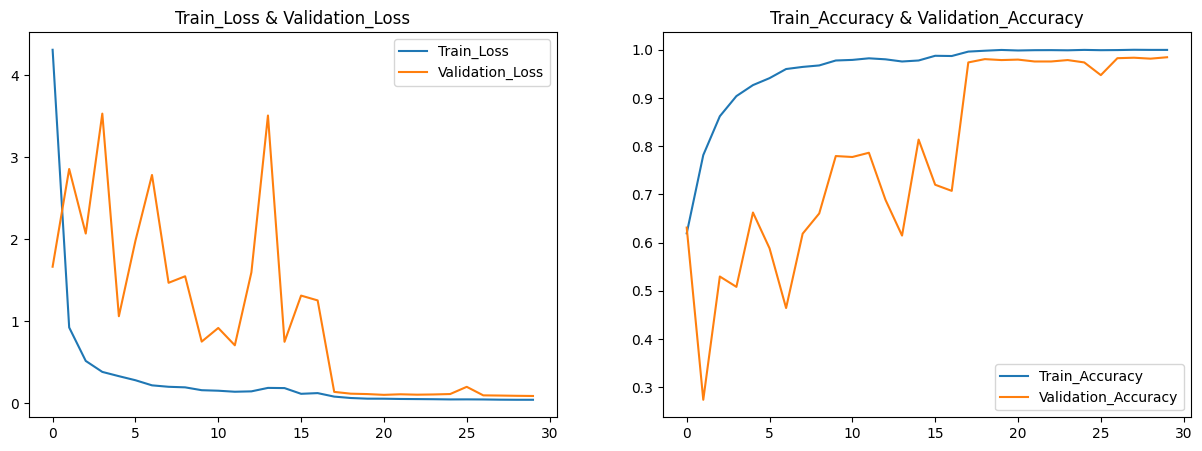

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy')
plt.legend()
plt.show()

In [21]:
score, acc= model.evaluate(test_data,test_labels)
print(f"Test Loss = {score:0.4f}")
print(f"Test Accuracy = {acc:0.1%}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.8293 - loss: 0.9240
Test Loss = 1.5693
Test Accuracy = 69.8%


In [22]:
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(test_labels,axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


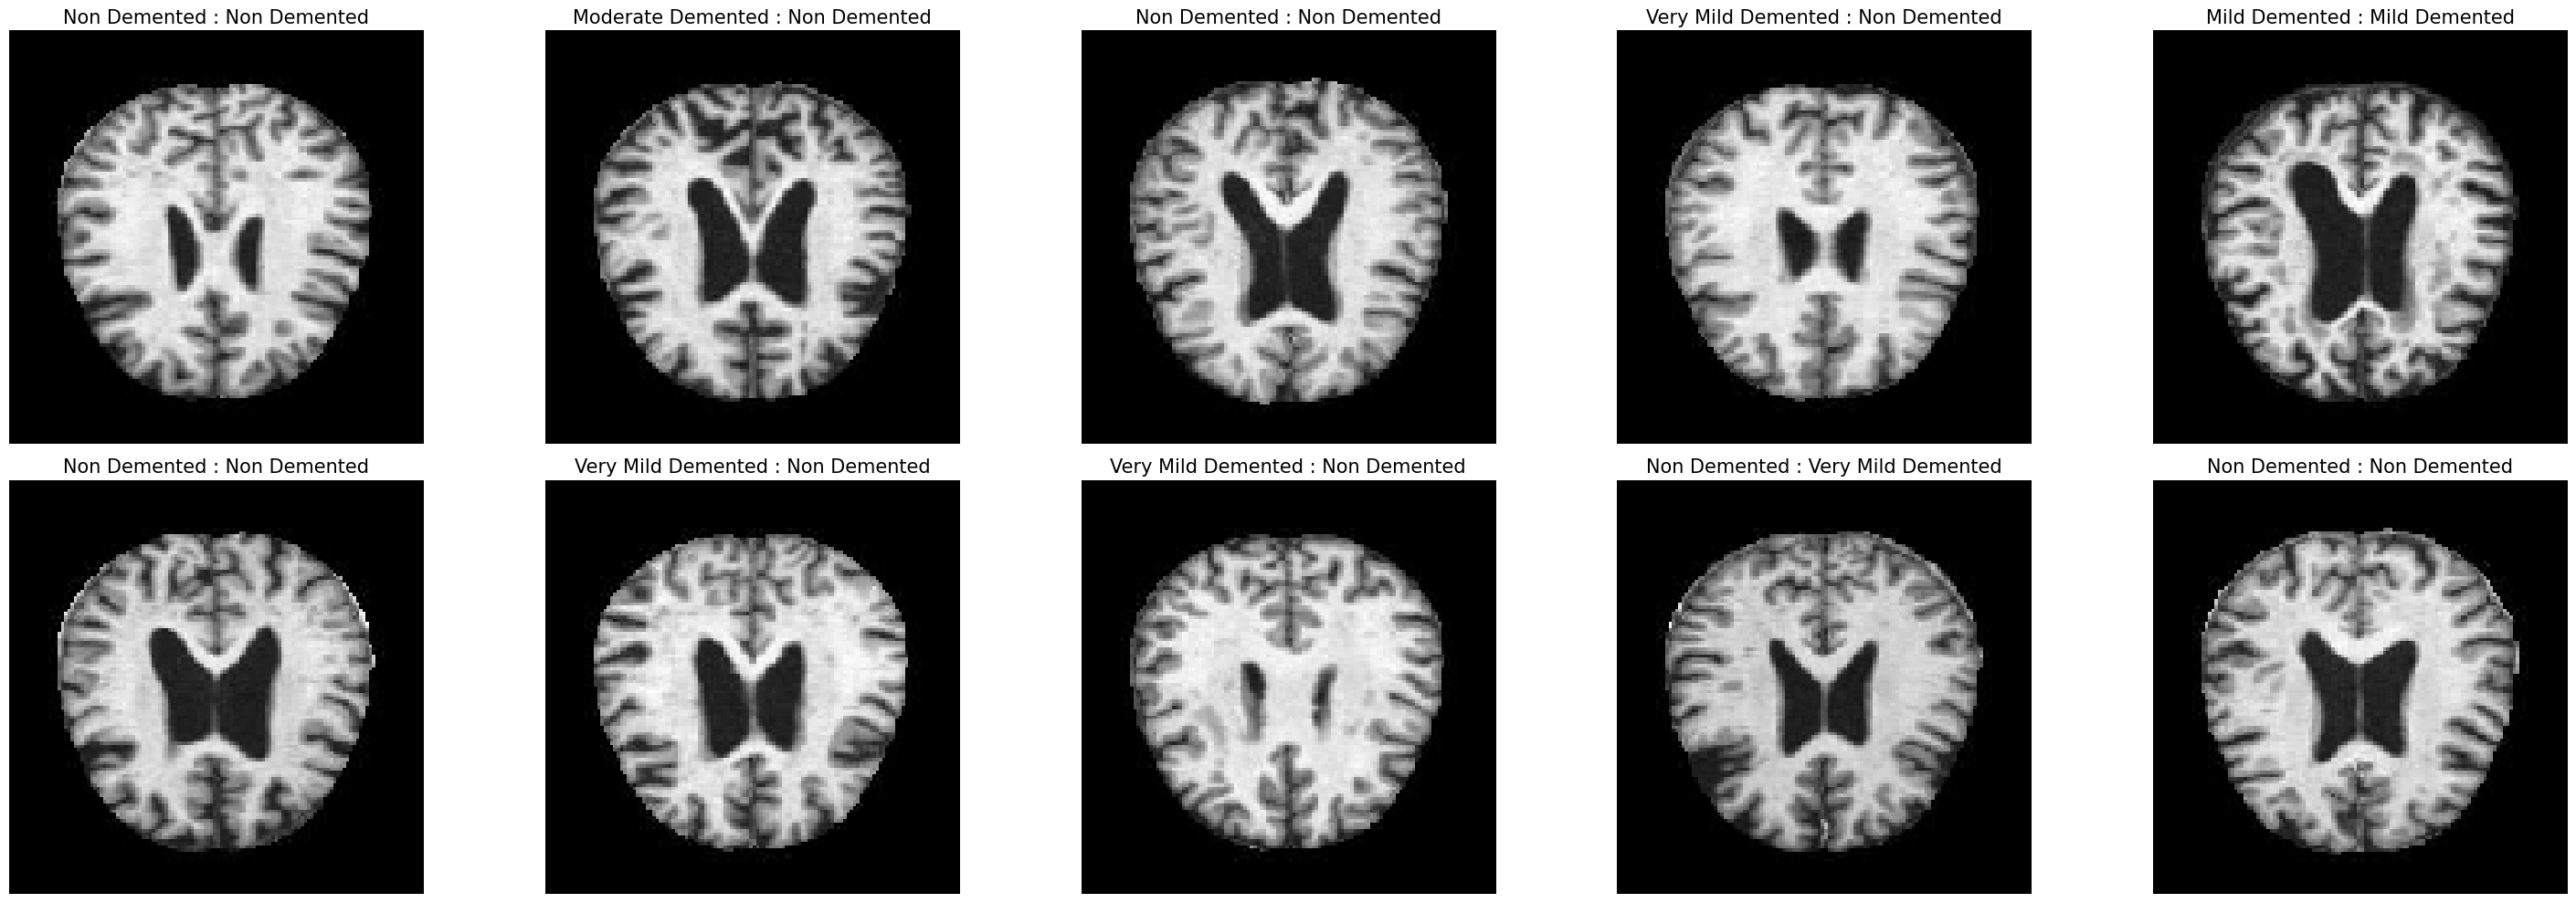

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust figure size for better visualization
plt.figure(figsize=(30, 10))

# Randomly select 10 unique samples
indices = np.random.choice(len(test_data), 10, replace=False)

# Loop through selected samples and plot
for n, i in enumerate(indices):
    plt.subplot(2, 5, n + 1)  # 2 rows, 5 columns grid
    plt.imshow(test_data[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} : {class_num[y_pred_classes[i]]}',fontsize=15)
    
plt.tight_layout()
plt.show()


array([[ 60,   0,  81,  38],
       [  0,   3,   5,   4],
       [  2,   0, 582,  56],
       [  4,   0, 196, 248]])

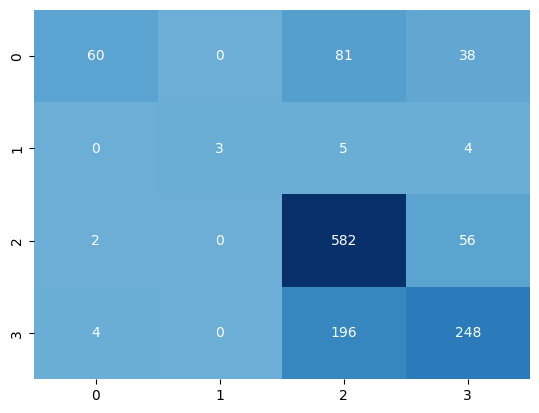

In [24]:
CM = confusion_matrix(y_test_,y_pred_classes)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [25]:
ClassificationReport = classification_report(y_test_,y_pred_classes)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.91      0.34      0.49       179
           1       1.00      0.25      0.40        12
           2       0.67      0.91      0.77       640
           3       0.72      0.55      0.62       448

    accuracy                           0.70      1279
   macro avg       0.82      0.51      0.57      1279
weighted avg       0.72      0.70      0.68      1279



# Last Change

In [63]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import warnings

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [64]:
# Initialize lists
images = []
labels = []
# Set the base directory
base_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
# Walk through the directory tree
for root, dirs, files in tqdm(os.walk(base_dir)):
    for file in files:
        # Construct the full image path
        image_path = os.path.join(root, file)
        # Extract the label from the parent folder name
        label = os.path.basename(os.path.dirname(image_path))
        # Append image path and label to respective lists
        images.append(image_path)
        labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'image': images, 'label': labels})
# Add space between capitalized words in the 'label' column
df['label'] = df['label'].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)
df

11it [00:01, 10.97it/s]


,image,label
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
...,...,...
6395,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented
6396,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented
6397,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented
6398,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented


In [65]:
Size=(128,128)
gen = ImageDataGenerator(
    rescale = 1./255
)
train_gen = gen.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6400, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [66]:
train_data, train_labels = next(train_gen)
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [67]:
class_num=np.sort(['Mild Demented','Moderate Demented','Non Demented','Very Mild Demented'])
class_num

array(['Mild Demented', 'Moderate Demented', 'Non Demented',
       'Very Mild Demented'], dtype='<U18')

In [68]:
# Step 1: First, split the data into training, validation, and test sets before any augmentation
X_train, X_test1, y_train, y_test1 = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True, stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)

# Flatten the training data for SMOTE application
sm = SMOTE(random_state=42)
X_train_flat, y_train = sm.fit_resample(X_train.reshape(-1, 128 * 128 * 3), y_train)

# Reshape the augmented training data back to the original image dimensions
X_train = X_train_flat.reshape(-1, 128, 128, 3)

# Output the shapes to check
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape)
print('X_val shape is ', X_val.shape)
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)
print('y_val shape is ', y_val.shape)

X_train shape is  (8960, 128, 128, 3)
X_test shape is  (960, 128, 128, 3)
X_val shape is  (960, 128, 128, 3)
y_train shape is  (8960, 4)
y_test shape is  (960, 4)
y_val shape is  (960, 4)


In [32]:
# Load pre-trained VGG16 model + higher-level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Adjust to the number of classes in your datase

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [33]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[model_checkpoint, early_stopping,reduce_lr])

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.5236 - loss: 1.2851 - val_accuracy: 0.6604 - val_loss: 0.7649 - learning_rate: 0.0010
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.7737 - loss: 0.5521 - val_accuracy: 0.6469 - val_loss: 0.7643 - learning_rate: 0.0010
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7947 - loss: 0.4805 - val_accuracy: 0.6406 - val_loss: 0.8012 - learning_rate: 0.0010
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8328 - loss: 0.4010 - val_accuracy: 0.7396 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8709 - loss: 0.3248 - val_accuracy: 0.6521 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8805 - loss: 0.2987 - val_accuracy: 0.7427 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9

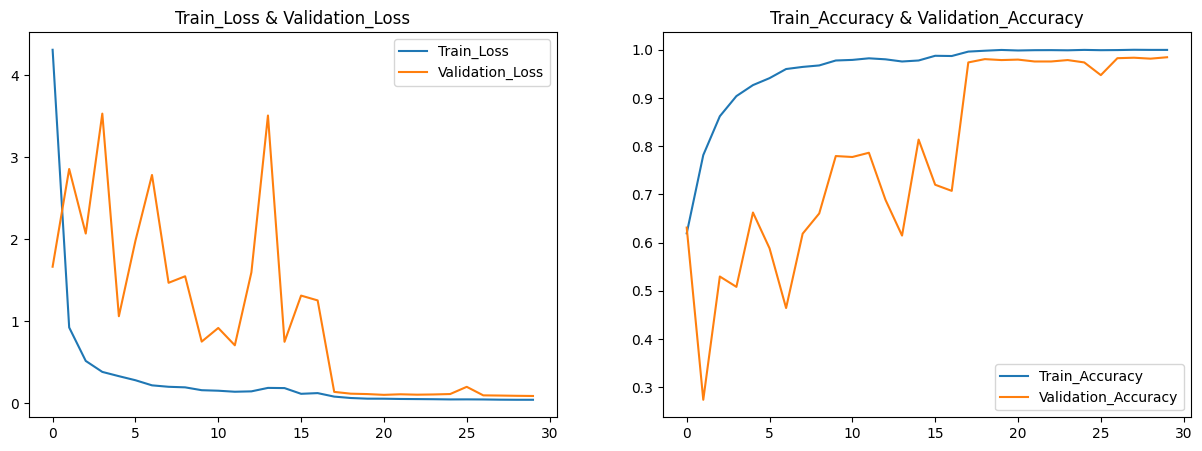

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy')
plt.legend()
plt.show()

In [35]:
score, acc= model.evaluate(X_test,y_test)
print(f"Test Loss = {score:0.4f}")
print(f"Test Accuracy = {acc:0.1%}")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test,axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9098 - loss: 0.3285
Test Loss = 0.3567
Test Accuracy = 90.1%
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


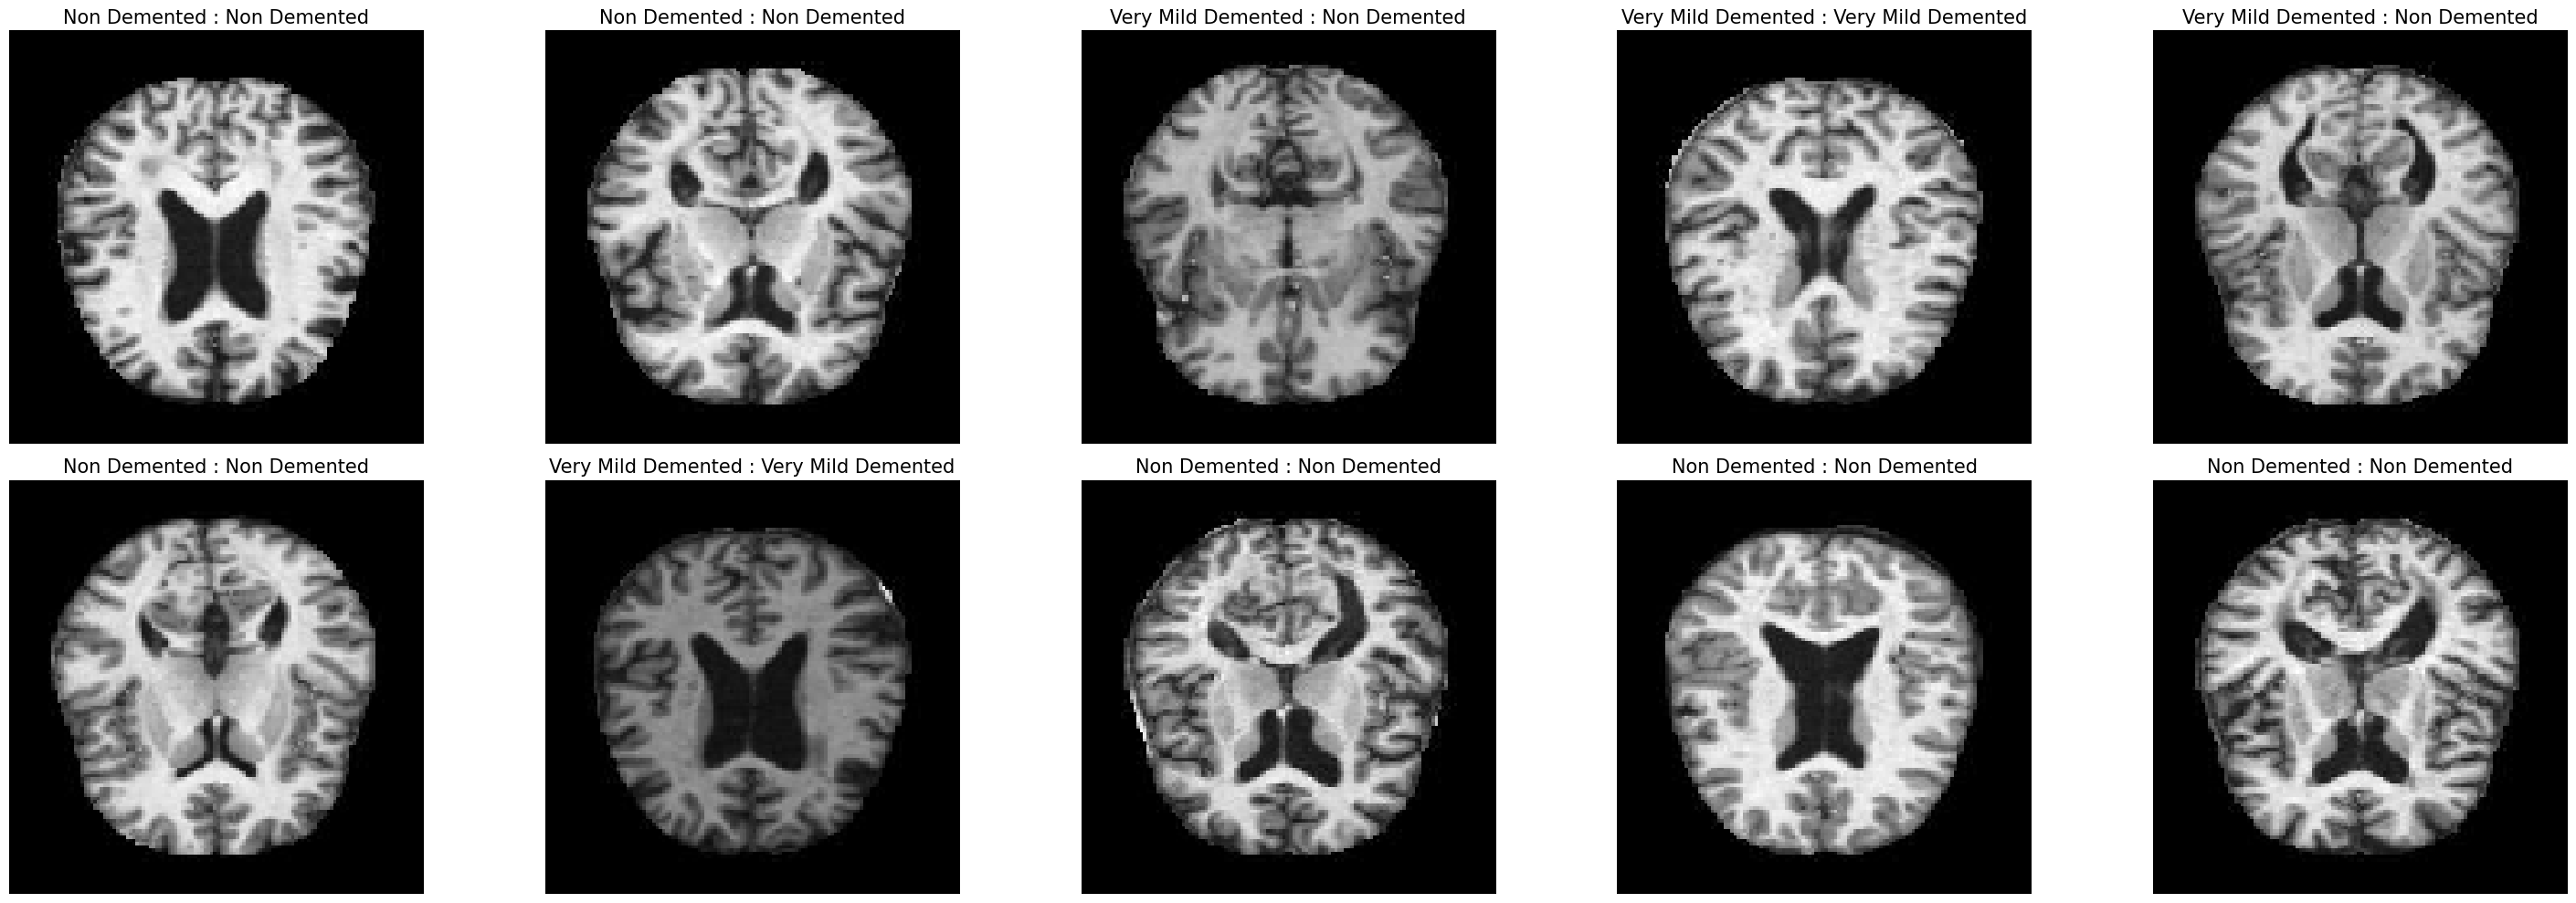

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust figure size for better visualization
plt.figure(figsize=(30, 10))

# Randomly select 10 unique samples
indices = np.random.choice(len(X_test), 10, replace=False)

# Loop through selected samples and plot
for n, i in enumerate(indices):
    plt.subplot(2, 5, n + 1)  # 2 rows, 5 columns grid
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} : {class_num[y_pred_classes[i]]}',fontsize=15)
    
plt.tight_layout()
plt.show()

array([[107,   0,  13,  14],
       [  0,   8,   0,   2],
       [  4,   0, 447,  29],
       [  4,   0,  29, 303]])

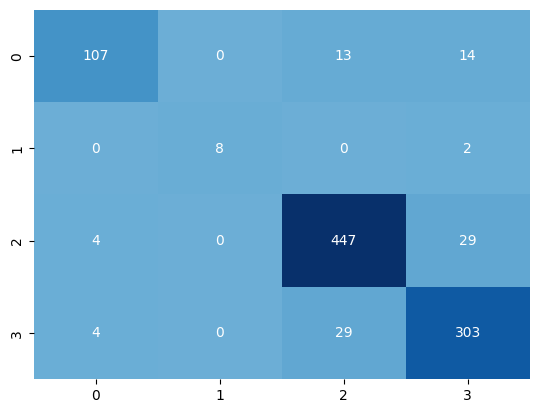

In [37]:
CM = confusion_matrix(y_test_,y_pred_classes)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM


In [38]:
ClassificationReport = classification_report(y_test_,y_pred_classes)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.93      0.80      0.86       134
           1       1.00      0.80      0.89        10
           2       0.91      0.93      0.92       480
           3       0.87      0.90      0.89       336

    accuracy                           0.90       960
   macro avg       0.93      0.86      0.89       960
weighted avg       0.90      0.90      0.90       960

